# Implementing simoncelli iteration into the manifold denoiser

Implementing a toy denoiser for the MNIST dataset from scratch. 
The denoiser is trained on the MNIST dataset with added noise. 

(1) Read a pretrain models
(2) Start from noise and iterate projecting into the manifold

### Refs:
[1] Z. Kadkhodaie and E. P. Simoncelli, “Solving Linear Inverse Problems Using the Prior Implicit in a Denoiser.” arXiv, May 06, 2021. Accessed: May 23, 2023. [Online]. Available: http://arxiv.org/abs/2007.13640



### TODO and log:
- read a pre-train model, verify it works reasonably well. 
- start from noise and check that the iteration process works well.


In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from datetime import datetime
import os
import logging

# Define experiment log directory and create it if it doesn't exist
EXPERIMENT_NAME = "dev_iterationloop"
log_dir = f'runs/{EXPERIMENT_NAME}_{datetime.now().strftime("%Y%m%d_%H:%M:%S")}'
os.makedirs(log_dir, exist_ok=True)

# Define experiment parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Set up logging and add relevant information
logging.basicConfig(
    filename=os.path.join(log_dir, "experiment.log"),
    level=logging.INFO,
    format=" %(message)s",
)
logging.info(
    "Experiment started at {}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
)
logging.info("Device: {}".format(device))

Using cuda device


# Get some toy data

In [2]:
# Download test data from open datasets. (Test Partition)
data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Create data loaders
batch_size = 64
dataloader = DataLoader(data, batch_size=batch_size)
print("Data loaders created")
print("Test data size: {}".format(len(data)))

for X, y in dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Data loaders created
Test data size: 10000
Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


# Init and load a pre-trained model

In [15]:
# Grab a pre-trained model.
from model import load_model

model_file = os.path.join("models", "denoiser.pt")
model = load_model(path=model_file)
model = model.to(device)  # Send to device
model.eval()  # Set model to evaluation mode


Denoiser(
  (bfcnn_first): bfcnn(
    (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (relu): ReLU()
  )
  (dfcnn_middle): ModuleList(
    (0-9): 10 x bfcnn(
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (relu): ReLU()
    )
  )
  (bfcnn_last): bfcnn(
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (conv): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (relu): ReLU()
  )
  (dropout): Dropout2d(p=0.5, inplace=False)
)

Text(0.5, 0.98, 'Denoised')

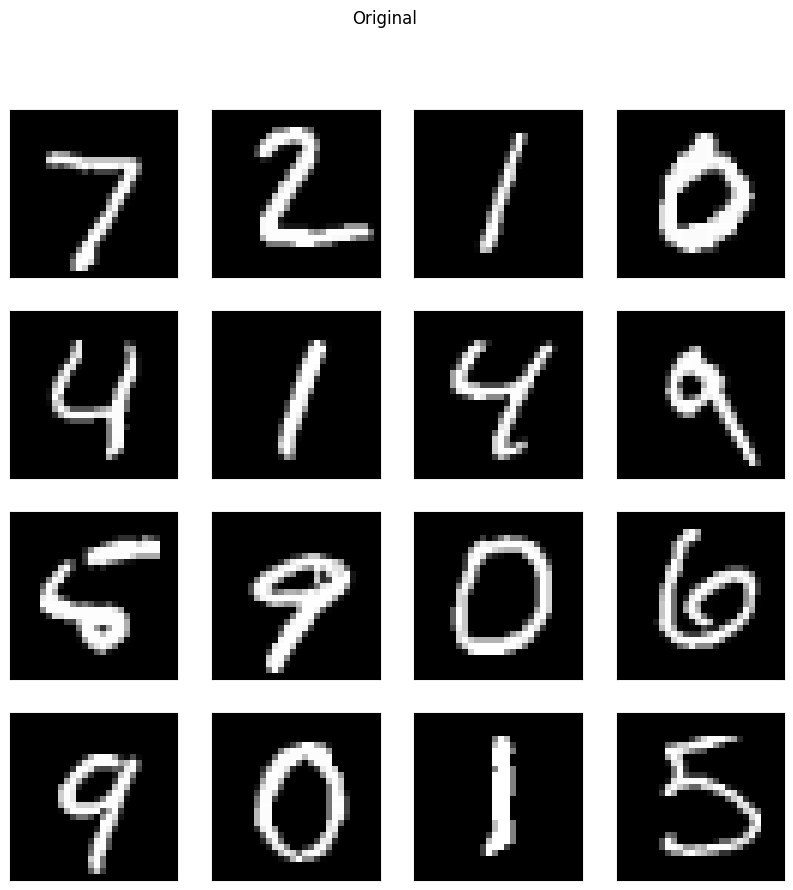

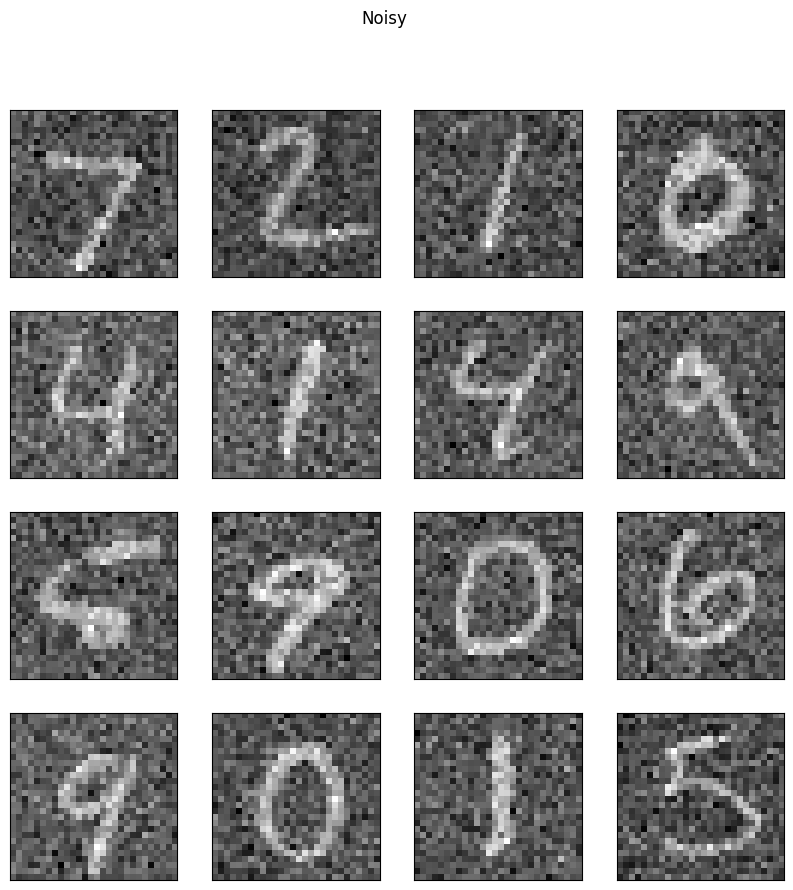

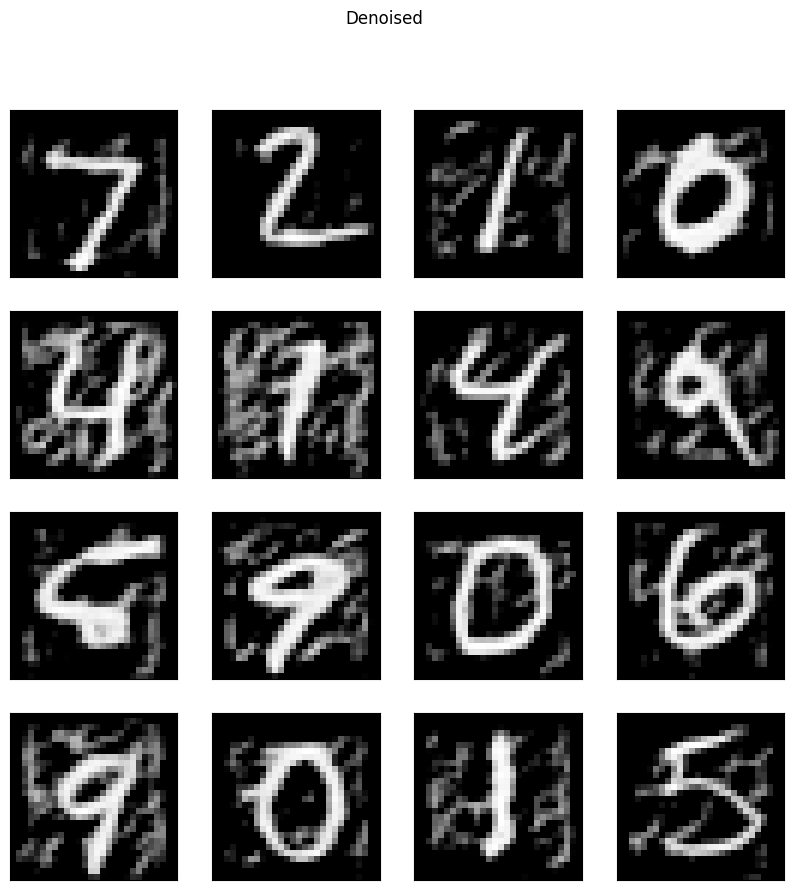

In [16]:
# Sanity check:: Test it works.
from utils import add_gaussian_noise, batch_img_normalize, show_batch

X = next(iter(dataloader))[0]  # Read a batch of data
X_noisy = batch_img_normalize(add_gaussian_noise(X))  # Add noise
X_denoised = model(X_noisy.to(device))  # De-noise using the model
X, X_noisy, X_denoised = X.to("cpu"), X_noisy.to("cpu"), X_denoised.to("cpu")

# Show the results
fig = show_batch(X[:16])
fig.suptitle("Original")
fig = show_batch(X_noisy[:16])
fig.suptitle("Noisy")
fig = show_batch(X_denoised[:16])
fig.suptitle("Denoised")

# Stochastic ascent method for sampling from the implicit prior 

Algorithm 1 [1].


In [ ]:
# 
import matplotlib.pyplot as plt
_, _, H, W = X.shape
y0 = torch.zeros(H, W)
y0 = add_gaussian_noise(img=y0, std=.5)
plt.imshow(y0, cmap="gray"); plt.title("y0 - Starting noisy image")

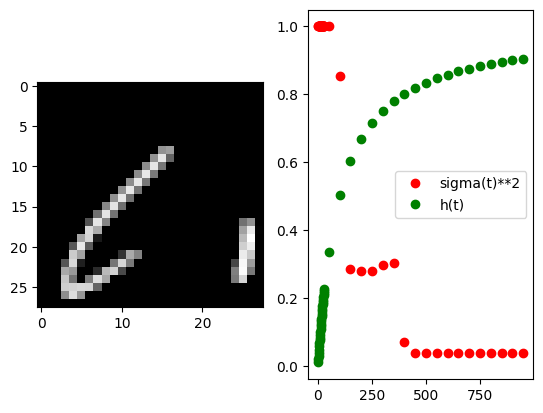

In [63]:
from utils import img_nomralize
import numpy as np
from IPython import display
%matplotlib inline


h0 = .01
beta = .5
sigma_0 = 1
_, _, H, W = X.shape
y0 = torch.zeros(H, W)
y0 = add_gaussian_noise(img=y0, std=sigma_0)

fig, axs = plt.subplots(1, 2)

for t in range(1, 1000):
    ht = (h0*t) / (1 + h0*(t-1))
    denoised = model(y0.view((1,1,H,W)).to(device)).view((H,W)).detach()
    dt = denoised.to("cpu") - y0
    sigma_t_2 = np.linalg.norm(dt)**2 / (H*W)
    gamma_t_2 = ((1-beta*ht)**2 - (1-ht)**2)*sigma_t_2
    
    zt = add_gaussian_noise(torch.randn(H, W), std=1)
    
    y1 = y0 + ht*dt + gamma_t_2*zt
    y0 = y1
    y0 = img_nomralize(y0)

    if t<30 or t % 50 == 0:
        axs[0].imshow(dt, cmap="gray")
        axs[1].plot([t], [min(1,1e3*sigma_t_2)], 'ro')
        axs[1].plot([t], [ht], 'go')
        axs[1].legend(["sigma(t)**2", "h(t)"])
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)
    


In [47]:
y0 = torch.zeros((H,W))
y0 = add_gaussian_noise(img=y0, std=1)
print(f'norm y0 {np.linalg.norm(y0)**2}, H*W {H*W}')

norm y0 734.6040745568607, H*W 784
